In [1]:
!gpu-who

/bin/bash: gpu-who: command not found


In [4]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
from import_for_notebooks import *
torch.set_default_dtype(torch.float64)

import common_utils
import analysis
import analysis_utils
from analysis import find_nearest_neighbour, scale, sort_by_metric

In [5]:
# in case you have your own sweep:
# sweep_id = '3s9e7mys'
# sweeps_dir = './data/sweeps/'
# sweep = analysis_utils.read_sweep(sweeps_dir, sweep_id, name=None, problem='cifar10_vehicles_animals')
# analysis_utils.download_sweep_results_from_wandb(sweep, max_runs_to_download=100)
# X = analysis_utils.get_all_reconstruction_outputs(sweep, verbose=True)

# read sweep parameters
sweep = common_utils.common.load_dict_to_obj("./reconstructions/fer2013_03/sweep.txt")
# read model, data, and whatever needed
args, Xtrn, Ytrn, ds_mean, W, model = analysis_utils.sweep_get_data_model(sweep, put_in_sweep=True, run_train_test=True)

OUTPUT_DIR: /home/da23c014/PrivacyAI/CourseProject/dataset_reconstruction/runs/2024_11_15_05_08_53_321167_fer_03_d250
Namespace(cuda=True, data_per_class_test=1000, data_per_class_train=250, data_per_class_val=0, data_reduce_mean=True, datasets_dir='/home/da23c014/PrivacyAI/CourseProject/datasets', device=device(type='cuda', index=0), extract_save_results=True, extract_save_results_every=10000, extraction_data_amount_per_class=500, extraction_epochs=50000, extraction_evaluate_rate=1000, extraction_init_scale=1e-09, extraction_lambda_lr=0.0001, extraction_loss_type='kkt', extraction_lr=0.0001, extraction_lr_l=0.0001, extraction_lr_x=0.0001, extraction_min_lambda=0.05, extraction_model_activation='modifiedrelu', extraction_model_relu_alpha=300, extraction_stop_threshold=5000, model_hidden_list=[1000, 1000], model_init_list=[0.001, 0.001], model_name='fer_03_d250', model_train_activation='relu', model_type='mlp', model_use_bias=False, output_dir='/home/da23c014/PrivacyAI/CourseProject/dat

BALANCING DATASET...
LOADING TESTSET
BALANCING DATASET...
X: torch.Size([500, 1, 48, 48])
y: torch.Size([500])
X: torch.Size([1000, 1, 48, 48])
y: torch.Size([1000])
BALANCE: 0: 250, 1: 250
BALNACENESS TRN: {0: 250, 1: 250}
BALNACENESS TST: {0: 500, 1: 500}
Initializing model weights - Only First Layer
Parameters per Layer: [tensor(2304000), tensor(1000), tensor(1000000), tensor(1000)]
Total Parameters: 3306000
loading weights '/home/da23c014/PrivacyAI/CourseProject/dataset_reconstruction/models/weights-fer_03_d250_fer_03_1.pth'
Train Error: 0.0 4.950044974659143e-06
Test  Error: 0.3490000069141388 3.080380130625249


In [6]:
# Read Reconstructed Data:

# "X" will contain a batch of all reconstructed samples (not all of them are good.. for this we need the rest of the cell)
# Here we put reconstructed data from two diffferent runs.
# you can use both of them or just one. (uncomment relevant parts)
x_paths = [
    '/home/da23c014/PrivacyAI/CourseProject/dataset_reconstruction/reconstructions/fer2013_03/49000_x.pth',
    '/home/da23c014/PrivacyAI/CourseProject/dataset_reconstruction/reconstructions/fer2013_03/49000_x_2nd_run.pth'
]
# X = torch.load(x_paths[0])
# X = torch.load(x_paths[1])
X = torch.cat([torch.load(x_paths[0]), torch.load(x_paths[1])])

CUT the end of the zipped bla because it might have different shape before torch.cat
torch.Size([990, 1, 48, 48]) 66


  0%|          | 0/17 [00:00<?, ?it/s]

0 0 60


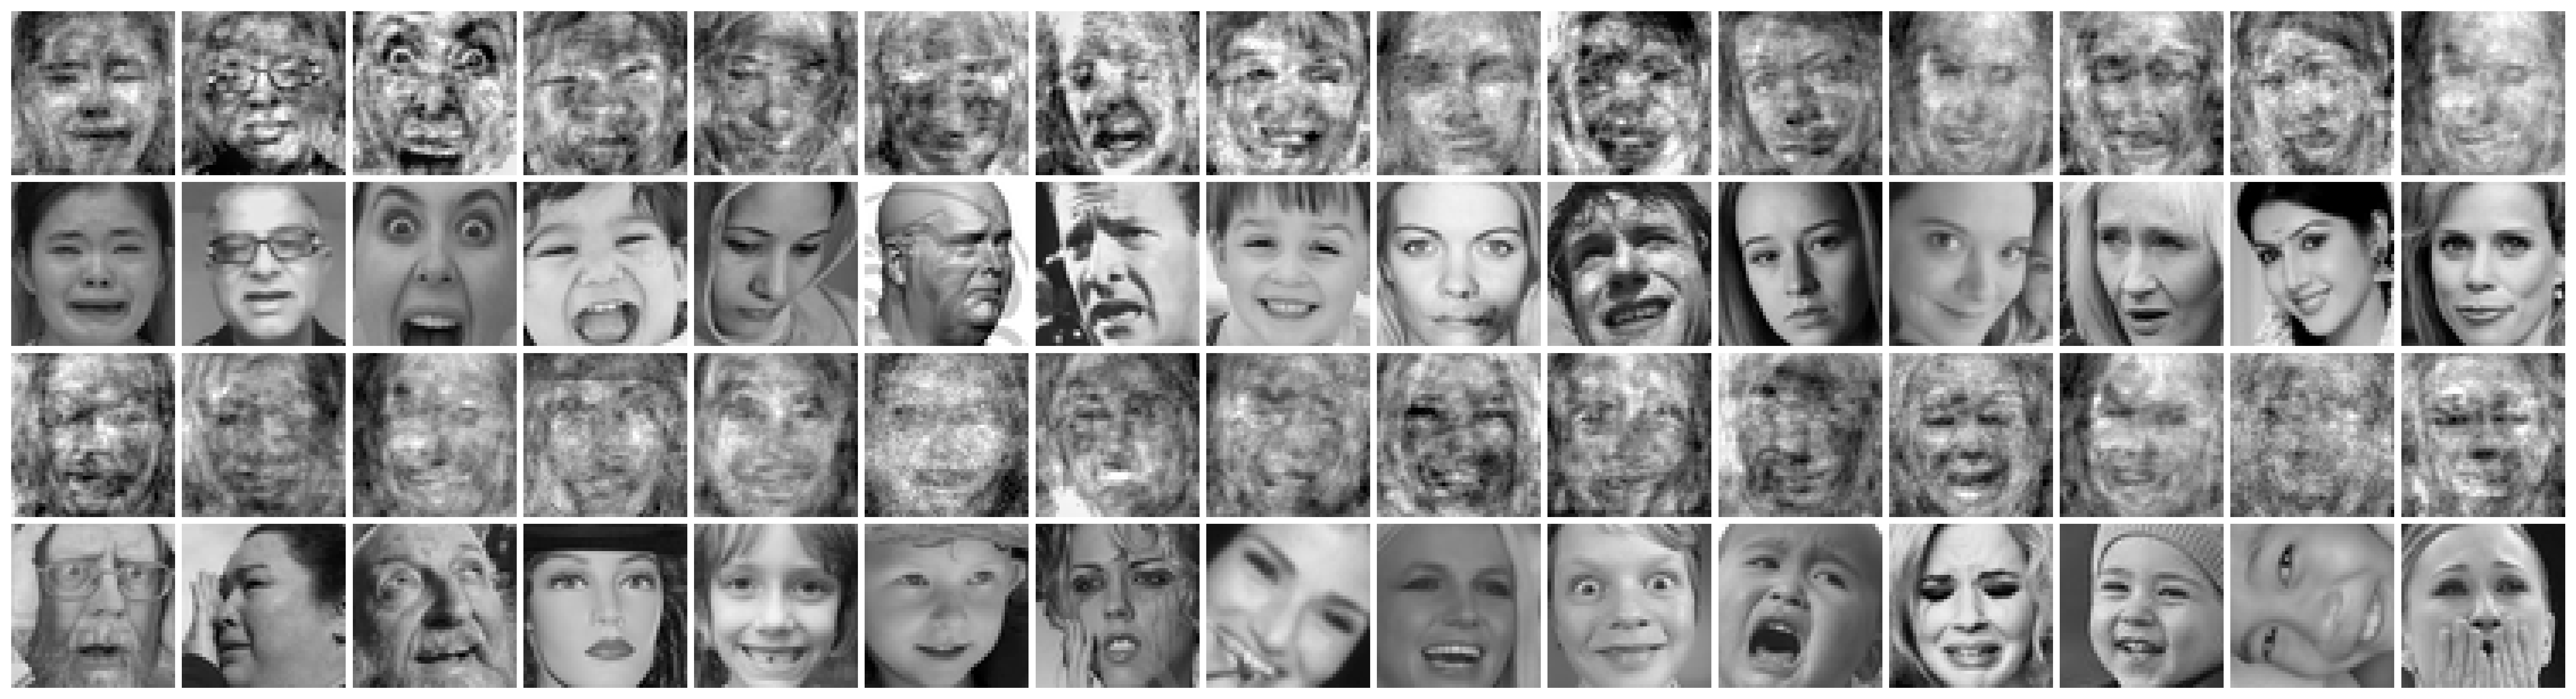

DONE!


In [7]:
# Find "Good" Resonctructions (as detailed in Appendix B.3):

# Find Nearest Neighbour
xx1 = find_nearest_neighbour(X, Xtrn, search='ncc', vote='min', use_bb=False, nn_threshold=1000)
# Scale to Images
xx_scaled, yy_scaled = scale(xx1, Xtrn, ds_mean)
# # Sort
xx, yy, ssims, sort_idxs = sort_by_metric(xx_scaled, yy_scaled, sort='ssim')
values = model(Xtrn).data

# Plot
# color_by_labels = Ytrn[sort_idxs]
color_by_labels = None
figpath=None
analysis.plot_table(xx, yy, fig_elms_in_line=15, fig_lines_per_page=4, fig_type='one_above_another', color_by_labels=color_by_labels, figpath=figpath, show=True, dpi=100)

## SSIM Scores

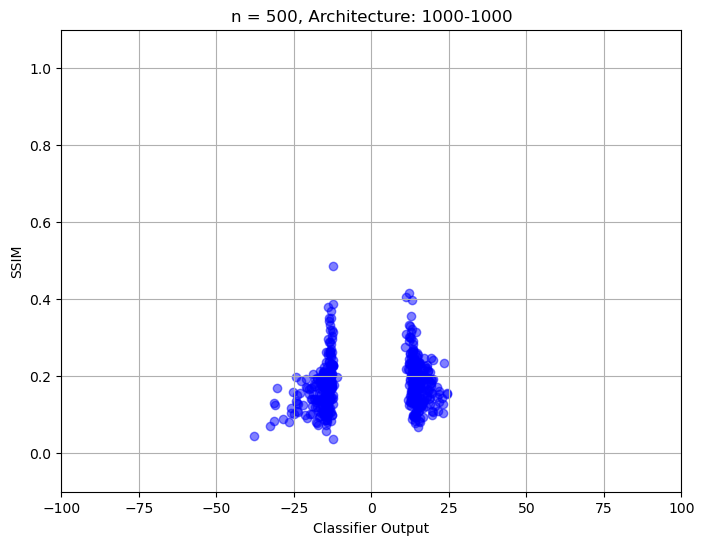

In [ ]:
import torch
import matplotlib.pyplot as plt
from analysis import find_nearest_neighbour, scale, sort_by_metric

# Load the data and model as in your previous code
# Assumes 'args', 'Xtrn', 'Ytrn', 'ds_mean', 'W', 'model' have been loaded from `sweep_get_data_model`

# Step 1: Generate reconstructions and classifier outputs
# Load reconstruction tensors (X) for analysis
x_paths = [
    '/home/da23c014/PrivacyAI/CourseProject/dataset_reconstruction/reconstructions/fer2013_03/49000_x.pth',
    '/home/da23c014/PrivacyAI/CourseProject/dataset_reconstruction/reconstructions/fer2013_03/49000_x_2nd_run.pth'
]
X = torch.cat([torch.load(x_paths[0]), torch.load(x_paths[1])])

# Step 2: Calculate SSIM Scores
# Find nearest neighbors in the training data
nearest_neighbors = find_nearest_neighbour(X, Xtrn, search='ncc', vote='min', use_bb=False, nn_threshold=1000)

# Scale and sort by SSIM metric
xx_scaled, yy_scaled = scale(nearest_neighbors, Xtrn, ds_mean)
xx, yy, ssims, sort_idxs = sort_by_metric(xx_scaled, yy_scaled, sort='ssim')

# Step 3: Get classifier outputs from the model
classifier_outputs = model(Xtrn).data.to('cpu').numpy()
 # Ensure outputs are on CPU for easy processing
sorted_classifier_outputs = classifier_outputs[sort_idxs.cpu()]
sorted_ssim_scores = ssims.cpu()[sort_idxs.cpu()]

# Step 4: Plot SSIM vs Classifier Output
# Since the classifier outputs and SSIM scores are aligned after sorting, we use sort_idxs to get aligned data
plt.figure(figsize=(8, 6))
plt.scatter(sorted_classifier_outputs, sorted_ssim_scores, color='blue', alpha=0.5)
plt.xlabel("Classifier Output")
plt.ylabel("SSIM")
plt.ylim(-0.1, 1.1)
plt.xlim(-100, 100)
plt.title("n = 500, Architecture: 1000-1000")
plt.grid(True)
plt.show()


## 1000-500-100-50 

In [9]:
# in case you have your own sweep:
# sweep_id = '3s9e7mys'
# sweeps_dir = './data/sweeps/'
# sweep = analysis_utils.read_sweep(sweeps_dir, sweep_id, name=None, problem='cifar10_vehicles_animals')
# analysis_utils.download_sweep_results_from_wandb(sweep, max_runs_to_download=100)
# X = analysis_utils.get_all_reconstruction_outputs(sweep, verbose=True)

# read sweep parameters
sweep = common_utils.common.load_dict_to_obj("./reconstructions/fer2013_03_2/sweep_model_2.txt")
# read model, data, and whatever needed
args, Xtrn, Ytrn, ds_mean, W, model = analysis_utils.sweep_get_data_model(sweep, put_in_sweep=True, run_train_test=True)

OUTPUT_DIR: /home/da23c014/PrivacyAI/CourseProject/dataset_reconstruction/runs/2024_11_15_05_10_51_770534_fer_03_d250
Namespace(cuda=True, data_per_class_test=1000, data_per_class_train=250, data_per_class_val=0, data_reduce_mean=True, datasets_dir='/home/da23c014/PrivacyAI/CourseProject/datasets', device=device(type='cuda', index=0), extract_save_results=True, extract_save_results_every=10000, extraction_data_amount_per_class=500, extraction_epochs=50000, extraction_evaluate_rate=1000, extraction_init_scale=1e-09, extraction_lambda_lr=0.0001, extraction_loss_type='kkt', extraction_lr=0.0001, extraction_lr_l=0.0001, extraction_lr_x=0.0001, extraction_min_lambda=0.05, extraction_model_activation='modifiedrelu', extraction_model_relu_alpha=300, extraction_stop_threshold=5000, model_hidden_list=[1000, 500, 100, 50], model_init_list=[0.0001, 0.0001, 0.001, 0.001], model_name='fer_03_d250', model_train_activation='relu', model_type='mlp', model_use_bias=True, output_dir='/home/da23c014/Priv

In [10]:
# Read Reconstructed Data:

# "X" will contain a batch of all reconstructed samples (not all of them are good.. for this we need the rest of the cell)
# Here we put reconstructed data from two diffferent runs.
# you can use both of them or just one. (uncomment relevant parts)
x_paths = [
    '/home/da23c014/PrivacyAI/CourseProject/dataset_reconstruction/reconstructions/fer2013_03_2/49000_x_2nd_run.pth',
    '/home/da23c014/PrivacyAI/CourseProject/dataset_reconstruction/reconstructions/fer2013_03_2/49000_x.pth']
# X = torch.load(x_paths[0])
# X = torch.load(x_paths[1])
X = torch.cat([torch.load(x_paths[0]), torch.load(x_paths[1])])

CUT the end of the zipped bla because it might have different shape before torch.cat
torch.Size([990, 1, 48, 48]) 66


  0%|          | 0/17 [00:00<?, ?it/s]

0 0 60


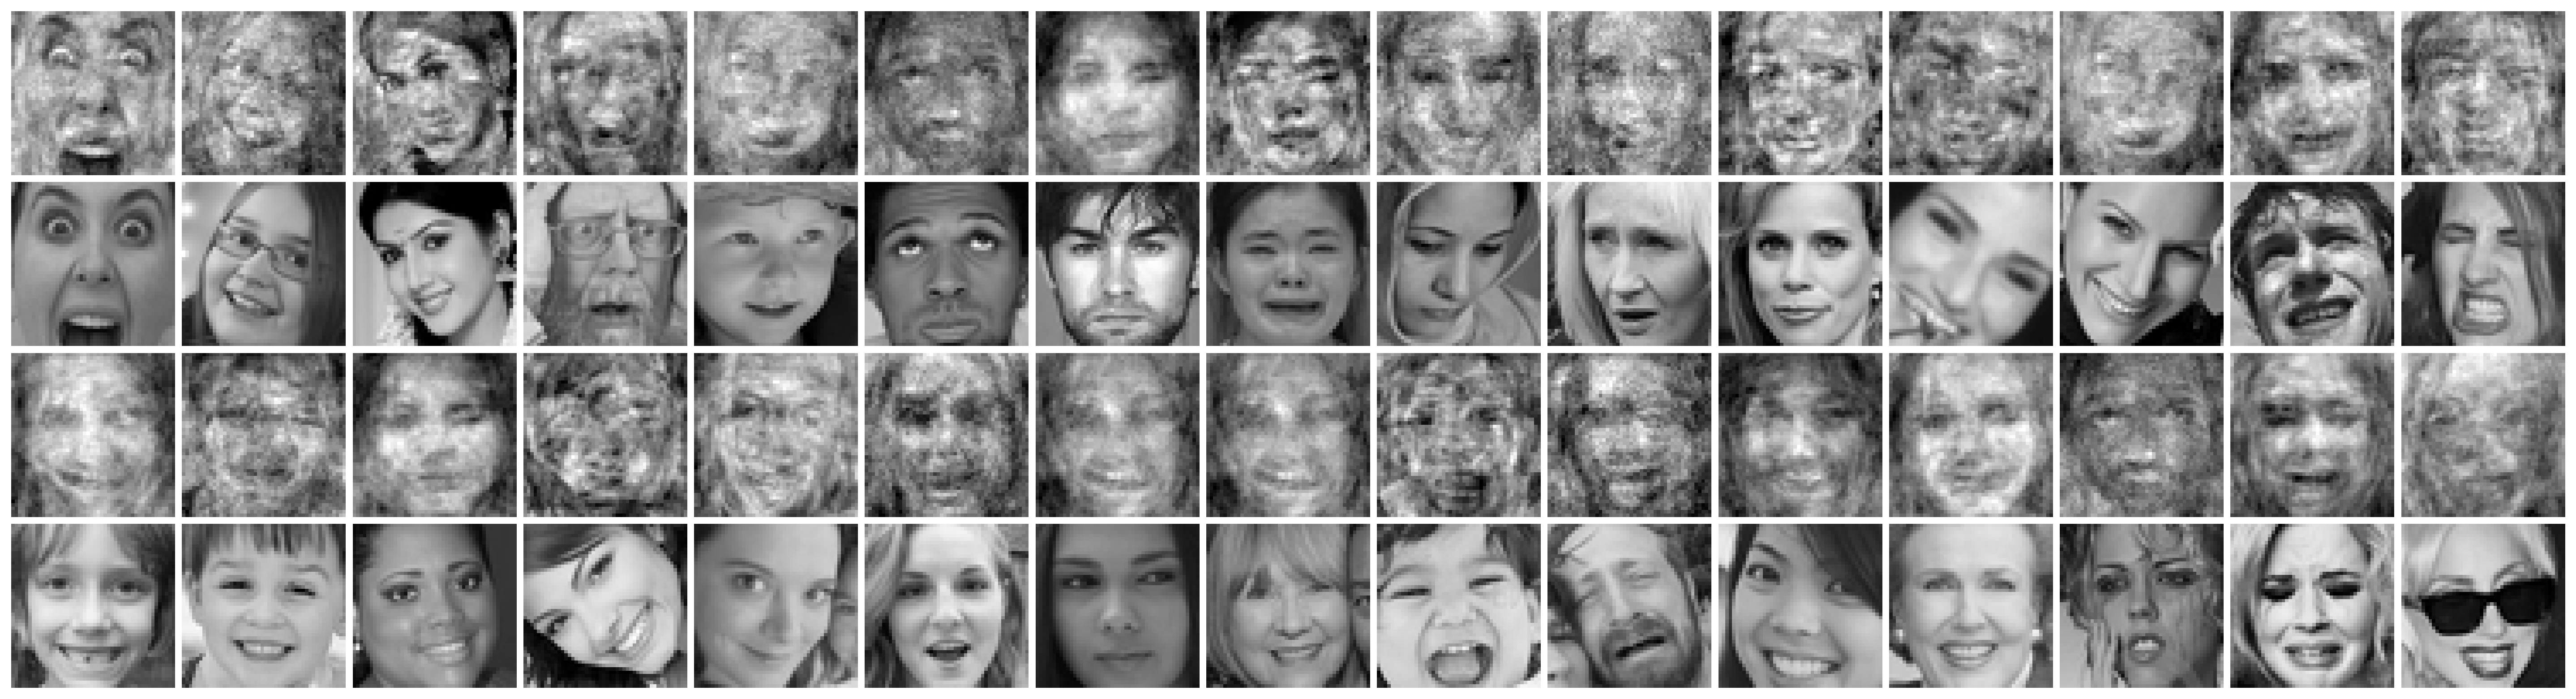

DONE!


In [11]:
# Find "Good" Resonctructions (as detailed in Appendix B.3):

# Find Nearest Neighbour
xx1 = find_nearest_neighbour(X, Xtrn, search='ncc', vote='min', use_bb=False, nn_threshold=1000)
# Scale to Images
xx_scaled, yy_scaled = scale(xx1, Xtrn, ds_mean)
# # Sort
xx, yy, ssims, sort_idxs = sort_by_metric(xx_scaled, yy_scaled, sort='ssim')
values = model(Xtrn).data

# Plot
# color_by_labels = Ytrn[sort_idxs]
color_by_labels = None
figpath=None
analysis.plot_table(xx, yy, fig_elms_in_line=15, fig_lines_per_page=4, fig_type='one_above_another', color_by_labels=color_by_labels, figpath=figpath, show=True, dpi=100)

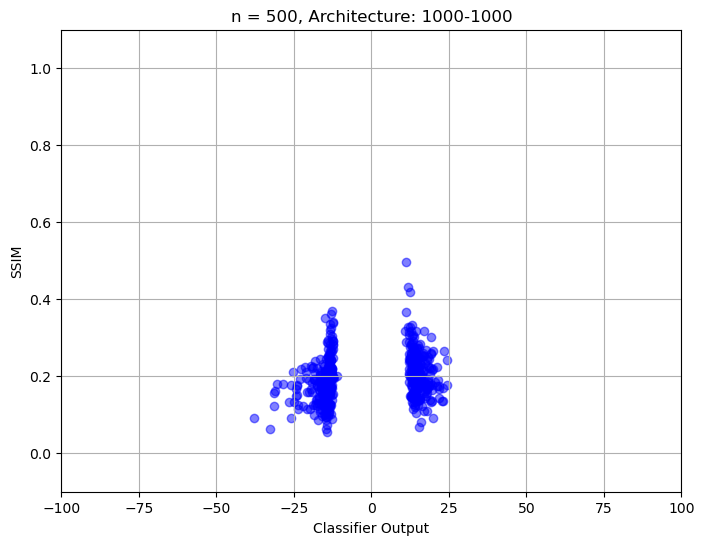

In [12]:
import torch
import matplotlib.pyplot as plt
from analysis import find_nearest_neighbour, scale, sort_by_metric

# Load the data and model as in your previous code
# Assumes 'args', 'Xtrn', 'Ytrn', 'ds_mean', 'W', 'model' have been loaded from `sweep_get_data_model`

# Step 1: Generate reconstructions and classifier outputs
# Load reconstruction tensors (X) for analysis
x_paths = [
    '/home/da23c014/PrivacyAI/CourseProject/dataset_reconstruction/reconstructions/fer2013_03_2/49000_x_2nd_run.pth',
    '/home/da23c014/PrivacyAI/CourseProject/dataset_reconstruction/reconstructions/fer2013_03_2/49000_x.pth']

X = torch.cat([torch.load(x_paths[0]), torch.load(x_paths[1])])

# Step 2: Calculate SSIM Scores
# Find nearest neighbors in the training data
nearest_neighbors = find_nearest_neighbour(X, Xtrn, search='ncc', vote='min', use_bb=False, nn_threshold=1000)

# Scale and sort by SSIM metric
xx_scaled, yy_scaled = scale(nearest_neighbors, Xtrn, ds_mean)
xx, yy, ssims, sort_idxs = sort_by_metric(xx_scaled, yy_scaled, sort='ssim')

# Step 3: Get classifier outputs from the model
classifier_outputs = model(Xtrn).data.to('cpu').numpy()
 # Ensure outputs are on CPU for easy processing
sorted_classifier_outputs = classifier_outputs[sort_idxs.cpu()]
sorted_ssim_scores = ssims.cpu()[sort_idxs.cpu()]

# Step 4: Plot SSIM vs Classifier Output
# Since the classifier outputs and SSIM scores are aligned after sorting, we use sort_idxs to get aligned data
plt.figure(figsize=(8, 6))
plt.scatter(sorted_classifier_outputs, sorted_ssim_scores, color='blue', alpha=0.5)
plt.xlabel("Classifier Output")
plt.ylabel("SSIM")
plt.ylim(-0.1, 1.1)
plt.xlim(-100, 100)
plt.title("n = 500, Architecture: 1000-1000")
plt.grid(True)
plt.show()